In [56]:
# download kaggle competition data
# use pip install kaggle if unable to run command
!kaggle competitions download -c facial-keypoints-detection

facial-keypoints-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [58]:
# once downlaoded unzip main data zip files and test training sub-zip files
import zipfile

with zipfile.ZipFile("facial-keypoints-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("facial_data")

with zipfile.ZipFile("facial_data/training.zip", 'r') as zip_ref:
    zip_ref.extractall("facial_data/training")

with zipfile.ZipFile("facial_data/test.zip", 'r') as zip_ref:
    zip_ref.extractall("facial_data/test")


In [59]:
# load data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, he_normal

from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [60]:
import dlib

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks/shape_predictor_68_face_landmarks.dat")

keys_leftEye = [37,38,40,41]
keys_rightEye = [43,44,46,47]
full_keypoints = [39,36,42,45,21,17,22,26,30,48,54,51,57,]

In [66]:
# load data
df = pd.read_csv("facial_data/training/training.csv")

# NA stratagy: fill in with 0? or drop completely
#clean_df = df.fillna("0") #(method = 'ffill',
#clean_df = df.dropna()

train_data = df.values
train_data[:,-1:].shape

(7049, 1)

In [75]:
Y = np.array(train_data[:,0:30], dtype = 'float') / 96.
print(np.sum(np.isnan(Y)))
#Y[np.isnan(Y)] = 0.
Y[0]

105412


array([0.68784962, 0.40627368, 0.31486466, 0.37939248, 0.62064662,
       0.41299398, 0.76177444, 0.41635414, 0.37871429, 0.38947293,
       0.24430075, 0.38947293, 0.59326316, 0.30243383, 0.83569925,
       0.33570977, 0.41903759, 0.30210752, 0.17037895, 0.30882782,
       0.46271429, 0.59444586, 0.63745113, 0.83302256, 0.29806767,
       0.80613534, 0.45117293, 0.75974436, 0.4492782 , 0.88006015])

In [76]:
# Convert image column to our X dataset reshaped to 96x96
X = []
for i in range(0, len(train_data)) :
    img = np.array(train_data[i,30].split(' '), dtype = 'float') / 255.
    #X.append(img)
    X.append(np.expand_dims(img.reshape(96,96), axis=2))
X = np.array(X, dtype = 'float')


In [77]:
X.shape

(7049, 96, 96, 1)

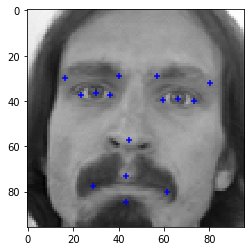

In [126]:
# first image
im_id=0

plt.imshow(X[im_id,:,:,0],cmap='gray')
for i in range(0,30,2) :
    plt.scatter(Y[im_id,i]*96., Y[im_id, i+1]*96., c='blue', marker='+')

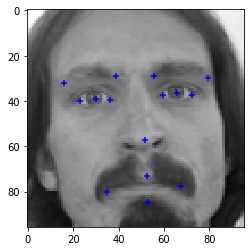

In [127]:
# mirror first image
plt.imshow(X[im_id,:,::-1,0],cmap='gray')
for i in range(0,30,2) :
    plt.scatter((1-Y[im_id,i])*96., Y[im_id, i+1]*96., c='blue', marker='+')

In [133]:
def Shape2Array(shape) :
    
    row = []
            
    lefteye_avg = np.zeros(2)
    righteye_avg = np.zeros(2)
    
    for i in keys_leftEye :
        lefteye_avg[0] += shape.part(i).x
        lefteye_avg[1] += shape.part(i).y
    lefteye_avg = lefteye_avg / 4.
    row.append(lefteye_avg[0])
    row.append(lefteye_avg[1])
        
    for i in keys_rightEye :
        righteye_avg[0] += shape.part(i).x
        righteye_avg[1] += shape.part(i).y
    righteye_avg = righteye_avg / 4.
    row.append(righteye_avg[0])
    row.append(righteye_avg[1])

    for i in full_keypoints :
        row.append(shape.part(i).x)
        row.append(shape.part(i).y)
    
    return row

Number of faces detected: 1
[(5, 14) (79, 88)] Detection 0: Left: 5 Top: 14 Right: 79 Bottom: 88
Part 0: (10, 44), Part 1: (8, 54) ...


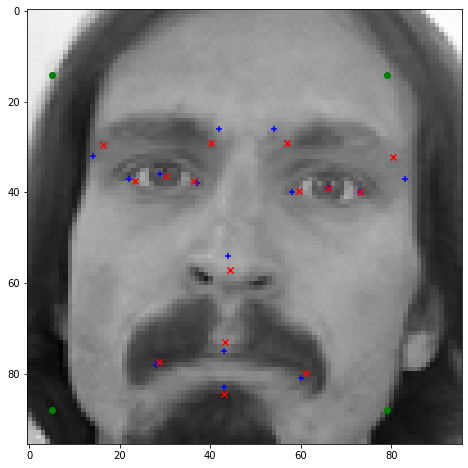

In [134]:
# Ask the detector to find the bounding boxes of each face. The 1 in the
# second argument indicates that we should upsample the image 1 time. This
# will make everything bigger and allow us to detect more faces.
img = (X[im_id,:,:,0]*255.).astype("uint8")

dets = detector(img, 1)
print("Number of faces detected: {}".format(len(dets)))
full_rect = dlib.rectangle(0, 0, 96, 96)

plt.figure(figsize=(8,8))
for k, d in enumerate(dets):
    print(d,"Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
        k, d.left(), d.top(), d.right(), d.bottom()))
    
    plt.scatter(d.left(), d.top(), c='green', marker='o')
    plt.scatter(d.left(), d.bottom(), c='green', marker='o')
    plt.scatter(d.right(), d.top(), c='green', marker='o')
    plt.scatter(d.right(), d.bottom(), c='green', marker='o')

    # Get the landmarks/parts for the face in box d.
    shape = predictor(img,full_rect)
    print("Part 0: {}, Part 1: {} ...".format(shape.part(0),
                                              shape.part(1)))
    
    dlib_row = Shape2Array(shape)

    plt.imshow(img,cmap='gray')
    for i in range(0,30,2) :
        plt.scatter(dlib_row[i], dlib_row[i+1], c='blue', marker='+')

    for i in range(0,30,2) :
        plt.scatter(Y[im_id,i]*96., Y[im_id, i+1]*96., c='red', marker='x')
    break

In [175]:
# filler Y dataframe
Full_Y = np.copy(Y)
for i in range(0, len(X)) :
    
    # fill in nans per row
    if np.sum(np.isnan(Y[i])) > 0 :
        img = (X[i,:,:,0]*255.).astype("uint8")
        shape = predictor(img,full_rect)

        dlib_row = Shape2Array(shape)

        null_indxs = np.array(np.where(np.isnan(Y[i,:]))).astype(int)[0]
        
#         print(np.sum(np.isnan(Y[i,:])), Full_Y[i, null_indxs])
#         print(null_indxs, np.array(dlib_row)[null_indxs], np.array(dlib_row)[null_indxs]/96.)
        
        Full_Y[i, null_indxs] = np.array(dlib_row)[null_indxs] / 96.
        
#         print(dlib_row[i])
#         print(Full_Y[i])
#        break

print(np.sum(np.isnan(Full_Y)))

0


In [176]:
# Sample starter model
model = tf.keras.Sequential()

'''
model.add(Flatten(input_shape=(96,96,1)))
model.add(Dense(512,activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(30))

'''
model.add(Convolution2D(32, (3,3), padding='same', input_shape=(96,96,1), kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', kernel_initializer=glorot_uniform(seed=0)))
#model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())


model.add(Flatten())
model.add(Dense(512,activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(30))


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 48, 48, 32)       

In [207]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


In [178]:
optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, 
              loss=root_mean_squared_error,
              metrics=[root_mean_squared_error, 'mse'])


In [194]:
#print(X[0],Y[0])

model.fit(X, Full_Y, epochs = 128, batch_size = 16, validation_split = 0.1, verbose=0) #

[0.69110584 0.37231335 0.32772225 0.36098957 0.62575746 0.3900095
 0.7542415  0.38182914 0.39710817 0.37935963 0.27311534 0.36967057
 0.6275002  0.30028754 0.8139038  0.29212087 0.40412426 0.3031176
 0.19966751 0.28304031 0.48994377 0.6477792  0.6276007  0.801622
 0.3341881  0.79161805 0.48951942 0.77067107 0.47516873 0.8974624 ]


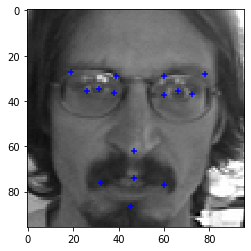

In [202]:
image_id = 111
a = model.predict(np.expand_dims(X[image_id], axis=0))[0]
print(a)

# predicted landmarks
img = X[image_id,:].reshape(96,96)
plt.imshow(img,cmap='gray')
for i in range(0,30,2) :
    plt.scatter(a[i]*96., a[i+1]*96., c='blue', marker='+')

In [201]:
from tensorflow.keras.models import load_model

# creates a HDF5 file
model.save('facial_landmarks.h5')  

# returns a compiled model
# identical to the previous one
#model = load_model('auto_encoder.h5')

In [205]:
# load test data
test_df = pd.read_csv("facial_data/test/test.csv")

#Drop the first column 'Id' since it just has serial numbers. Not useful in the prediction process.
#test_df = test_df.iloc[:,1:]
test_data = test_df.values


# Convert image column to our X dataset reshaped to 96x96
X_test = []
for i in range(0, len(test_data)) :
    img = np.array(test_data[i,1].split(' '), dtype = 'float') / 255.
    X_test.append(np.expand_dims(img.reshape(96,96), axis=2))
X_test = np.array(X_test, dtype = 'float')


In [210]:
from tensorflow.keras.models import load_model

model = load_model('facial_landmarks.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

[[0.68945384 0.4051367  0.32209593 0.41895223 0.6047137  0.4250075
  0.7615047  0.4244903  0.40378952 0.42992395 0.2618286  0.4408532
  0.59147364 0.32662508 0.7933046  0.32858178 0.37917152 0.34196916
  0.19961467 0.35917747 0.48069254 0.55054533 0.67610514 0.8156841
  0.33272964 0.8185905  0.5010184  0.7686772  0.4909136  0.87139356]] 
time: 0.028894901275634766


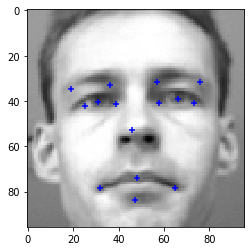

In [222]:
import time
#for i in range
image_id = 3
pred_img = np.expand_dims(X_test[image_id], axis=0)
start_time=time.time()
a = model.predict(pred_img)
print(a,"\ntime:",time.time()-start_time)

# predicted landmarks
img = X_test[image_id,:].reshape(96,96)
plt.imshow(img,cmap='gray')
for i in range(0,30,2) :
    plt.scatter(a[0,i]*96., a[0,i+1]*96., c='blue', marker='+')

In [14]:
# train auto encoder on all images

# Convert image column to our X dataset reshaped to 96x96
X_all = []
for i in range(0, len(all_images)) :
    img = np.array(all_images[i].split(' '), dtype = 'float') / 255.
    #X.append(img)
    X_all.append(np.expand_dims(img.reshape(96,96), axis=2))
X_all = np.array(X_all, dtype = 'float')
X_all.shape

(8832, 96, 96, 1)

In [15]:
# Sample starter model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import UpSampling2D
model = tf.keras.Sequential()

## Encoder
model.add(Convolution2D(32, (3,3), padding='same', input_shape=(96,96,1), kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))

model.add(Convolution2D(32, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))

model.add(Convolution2D(64, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))

model.add(Convolution2D(96, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))

model.add(Convolution2D(128, (3,3),padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))

## Decoder
# remove this section?
model.add(Convolution2D(128, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))

model.add(UpSampling2D(size=(2, 2)))
model.add(Convolution2D(96, (3,3), padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))

model.add(UpSampling2D(size=(2, 2)))
model.add(Convolution2D(64, (3,3),padding='same', kernel_initializer=glorot_uniform(seed=0)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha = 0.1))

model.add(UpSampling2D(size=(2, 2)))
model.add(Convolution2D(32, (3,3),padding='same', activation='relu',kernel_initializer=glorot_uniform(seed=0)))

model.add(Convolution2D(1, (3,3), padding='same', activation='sigmoid', kernel_initializer=glorot_uniform(seed=0)))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)       

In [16]:
from tensorflow.keras.losses import binary_crossentropy, mean_squared_error 
import tensorflow.keras.backend as K

#this contains both X and Y sobel filters in the format (3,3,1,2)
#size is 3 x 3, it considers 1 input channel and has two output channels: X and Y
sobelFilter = K.variable([[[[1.,  1.]], [[0.,  2.]],[[-1.,  1.]]],
                      [[[2.,  0.]], [[0.,  0.]],[[-2.,  0.]]],
                      [[[1., -1.]], [[0., -2.]],[[-1., -1.]]]])

def expandedSobel(inputTensor):

    #this considers data_format = 'channels_last'
    inputChannels = K.reshape(K.ones_like(inputTensor[0,0,0,:]),(1,1,-1,1))
    #if you're using 'channels_first', use inputTensor[0,:,0,0] above

    return sobelFilter * inputChannels

def sobelLoss(yTrue,yPred):

    #get the sobel filter repeated for each input channel
    filt = expandedSobel(yTrue)

    #calculate the sobel filters for yTrue and yPred
    #this generates twice the number of input channels 
    #a X and Y channel for each input channel
    sobelTrue = tf.keras.backend.depthwise_conv2d(yTrue,filt)
    sobelPred = tf.keras.backend.depthwise_conv2d(yPred,filt)

    #now you just apply the mse:
    return K.mean(K.square(sobelTrue - sobelPred))

def bce_sobel(y_true, y_pred):
    bmse = sobelLoss(y_true, y_pred)
    crossentropy = weighted_binary_crossentropy(y_true, y_pred)
    return  crossentropy+bmse

In [18]:
optimizer = optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='mse', metrics=['mse', 'accuracy'])
#model.compile(optimizer='adadelta', loss='binary_crossentropy',metrics=['mse', 'accuracy'])

model.fit(X_all,X_all,epochs = 8,batch_size = 64) #, validation_split = 0.2

Epoch 1/8
8832/8832 [==============================] - 17s 2ms/sample - loss: 0.0022 - mean_squared_error: 0.0022 - acc: 0.0061
Epoch 2/8
8832/8832 [==============================] - 17s 2ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - acc: 0.0061
Epoch 3/8
8832/8832 [==============================] - 16s 2ms/sample - loss: 0.0020 - mean_squared_error: 0.0020 - acc: 0.0061
Epoch 4/8
8832/8832 [==============================] - 16s 2ms/sample - loss: 0.0018 - mean_squared_error: 0.0018 - acc: 0.0061
Epoch 5/8
8832/8832 [==============================] - 16s 2ms/sample - loss: 0.0018 - mean_squared_error: 0.0018 - acc: 0.0061
Epoch 6/8
8832/8832 [==============================] - 16s 2ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - acc: 0.0061
Epoch 7/8
8832/8832 [==============================] - 16s 2ms/sample - loss: 0.0016 - mean_squared_error: 0.0016 - acc: 0.0061
Epoch 8/8
8832/8832 [==============================] - 16s 2ms/sample - loss: 0.0015 - mean_squared_erro

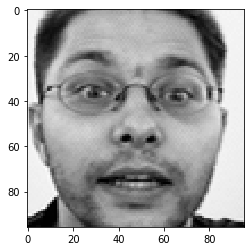

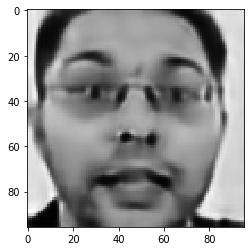

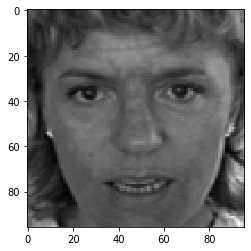

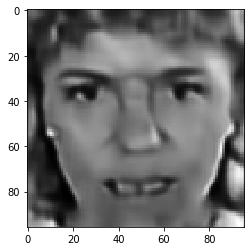

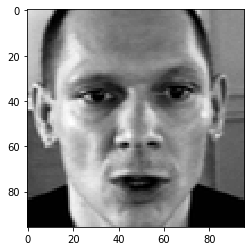

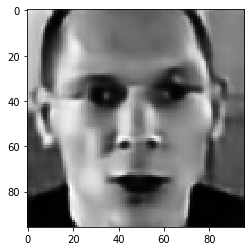

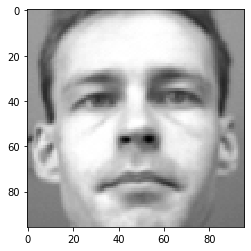

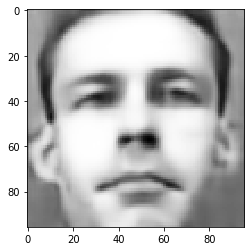

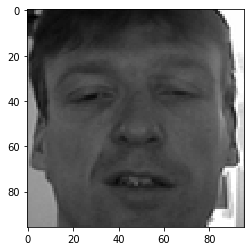

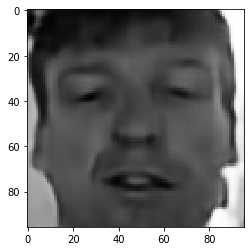

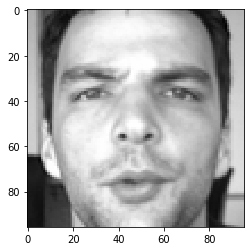

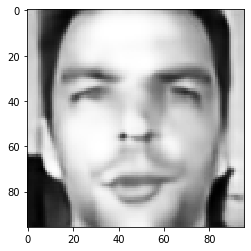

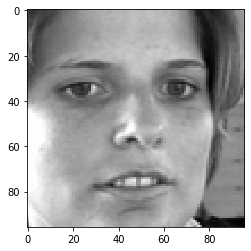

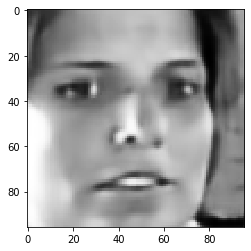

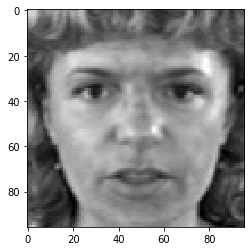

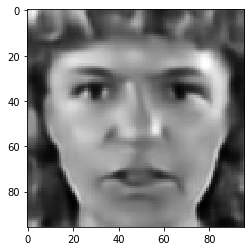

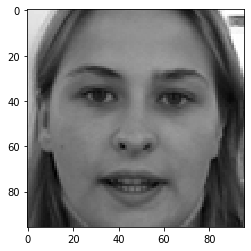

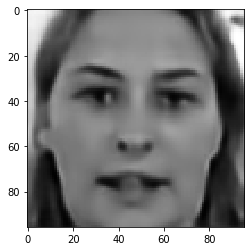

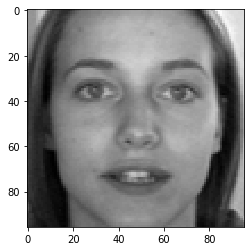

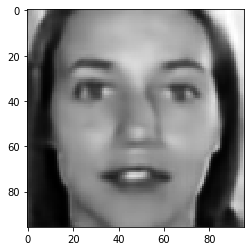

In [19]:
for img_id in range(0,10) :
    img = model.predict(np.expand_dims(X_all[img_id], axis=0))[0]
    img.shape
    # predicted landmarks
    plt.imshow(X_all[img_id,:,:,0],cmap='gray')
    plt.show()
    plt.imshow(img[:,:,0],cmap='gray')
    plt.show()


In [11]:
from tensorflow.keras.models import load_model

#model.save('auto_encoder.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
autoencoder = load_model('auto_encoder.h5')

In [14]:
# delete last layers and append our two classification layers
classifier = Sequential()
for i in range(0, 27):
    layer = autoencoder.layers[i]
    #layer.trainable = False
    classifier.add(layer)

classifier.add(Flatten())
classifier.add(Dense(512,activation='sigmoid'))
classifier.add(Dropout(0.1))
classifier.add(Dense(30))

classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_304 (Conv2D)          (None, 96, 96, 32)        320       
_________________________________________________________________
batch_normalization_276 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
leaky_re_lu_279 (LeakyReLU)  (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_305 (Conv2D)          (None, 96, 96, 32)        9248      
_________________________________________________________________
batch_normalization_277 (Bat (None, 96, 96, 32)        128       
_________________________________________________________________
leaky_re_lu_280 (LeakyReLU)  (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 48, 48, 32)       

In [15]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 


In [17]:
optimizer = optimizers.Adam(learning_rate=0.0001)

classifier.compile(optimizer=optimizer, 
              loss=root_mean_squared_error,
              metrics=['mse', 'accuracy'])

classifier.fit(X,Y,epochs = 4,batch_size = 32) #, validation_split = 0.2

Epoch 1/4
7049/7049 [==============================] - 9s 1ms/sample - loss: 0.1544 - mean_squared_error: 0.0242 - acc: 0.7110
Epoch 2/4
7049/7049 [==============================] - 9s 1ms/sample - loss: 0.1333 - mean_squared_error: 0.0182 - acc: 0.7512
Epoch 3/4
7049/7049 [==============================] - 9s 1ms/sample - loss: 0.1190 - mean_squared_error: 0.0146 - acc: 0.7847
Epoch 4/4
7049/7049 [==============================] - 9s 1ms/sample - loss: 0.1076 - mean_squared_error: 0.0119 - acc: 0.7868


[0.7044361  0.42334256 0.30375716 0.3903979  0.56067353 0.41033977
 0.7113799  0.37450844 0.33746618 0.40060896 0.24038199 0.3509846
 0.5700877  0.27714968 0.76808375 0.33564094 0.3574522  0.3103235
 0.14931595 0.25679064 0.52916425 0.6423625  0.5769131  0.7507807
 0.2901902  0.7170269  0.46196815 0.6631255  0.49445984 0.8622455 ]


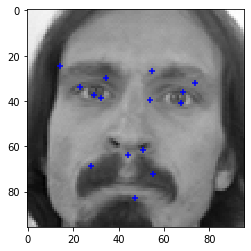

In [18]:
image_id = 0
a = classifier.predict(np.expand_dims(X[image_id], axis=0))[0]
print(a)

# predicted landmarks
img = X[image_id,:].reshape(96,96)
plt.imshow(img,cmap='gray')
for i in range(0,30,2) :
    plt.scatter(a[i]*96., a[i+1]*96., c='blue', marker='+')

In [216]:
#classifier.save('classifier_model.h5')  # creates a HDF5 file 'my_model.h5'
